In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [40]:
NYSE_Weather = pd.read_csv('../data/NYSE_Weather.csv')
NYC_no_outliers = pd.read_csv('../data/NYC_no_outliers.csv')
Monthly_NYC = pd.read_csv('../data/Monthly_averages.csv')

In [41]:
NYSE_Weather.head()

,Date,Open,Close,Volume,Returns,Hours_of_Sunlight,HOS_Numeric,temp,humidity,precip,preciptype,snow,windspeed,cloudcover,visibility,sunrise,sunset,conditions,description
0,1985-01-03,1005.030029,1005.030029,0.0,-0.398390,0 days 09:20:42,9.345000,0.3,54.6,0.000,none,0.0,26.2,100.0,25.2,07:20:26,16:41:08,Overcast,Cloudy skies throughout the day.
1,1985-01-04,1000.270020,1000.270020,0.0,-0.473619,0 days 09:21:36,9.360000,-1.1,58.1,1.247,"rain,snow",0.0,23.0,99.1,18.9,07:20:26,16:42:02,"Snow, Rain, Overcast",Cloudy skies throughout the day with late afte...
2,1985-01-07,1003.340027,1003.340027,0.0,0.306918,0 days 09:24:39,9.410833,2.9,78.3,0.000,none,0.0,22.1,99.3,13.3,07:20:15,16:44:54,Overcast,Cloudy skies throughout the day.
3,1985-01-08,1002.500000,1002.500000,0.0,-0.083723,0 days 09:25:46,9.429444,-1.5,57.0,0.000,none,0.0,46.8,32.1,29.5,07:20:07,16:45:53,Partially cloudy,Partly cloudy throughout the day.
4,1985-01-09,1009.159973,1009.159973,0.0,0.664336,0 days 09:26:59,9.449722,-7.9,51.4,0.000,none,0.0,40.8,0.9,34.5,07:19:56,16:46:55,Clear,Clear conditions throughout the day.


In [42]:
#One-Hot Encode the conditions column

# one-hot encoding each individual condition in a seprate dataframe which will then be added to the original
one_hot_encoded_data = pd.DataFrame()

# Split the combined condition into a list of individual conditions
conditions = NYSE_Weather['conditions'].str.split(', ')

for index, condition_list in enumerate(conditions):
    for condition in condition_list:
        # Create binary columns for each condition
        one_hot_encoded_data.at[index, condition.strip()] = 1

# Fill NaN values with 0
one_hot_encoded_data = one_hot_encoded_data.fillna(0).astype(int)

# Concatenate the one-hot encoded data with original NYSE_Weather df
NYSE_Weather = pd.concat([NYSE_Weather, one_hot_encoded_data], axis=1)


In [43]:
NYSE_Weather.head()


,Date,Open,Close,Volume,Returns,Hours_of_Sunlight,HOS_Numeric,temp,humidity,precip,...,sunset,conditions,description,Overcast,Snow,Rain,Partially cloudy,Clear,Freezing Drizzle/Freezing Rain,Ice
0,1985-01-03,1005.030029,1005.030029,0.0,-0.398390,0 days 09:20:42,9.345000,0.3,54.6,0.000,...,16:41:08,Overcast,Cloudy skies throughout the day.,1,0,0,0,0,0,0
1,1985-01-04,1000.270020,1000.270020,0.0,-0.473619,0 days 09:21:36,9.360000,-1.1,58.1,1.247,...,16:42:02,"Snow, Rain, Overcast",Cloudy skies throughout the day with late afte...,1,1,1,0,0,0,0
2,1985-01-07,1003.340027,1003.340027,0.0,0.306918,0 days 09:24:39,9.410833,2.9,78.3,0.000,...,16:44:54,Overcast,Cloudy skies throughout the day.,1,0,0,0,0,0,0
3,1985-01-08,1002.500000,1002.500000,0.0,-0.083723,0 days 09:25:46,9.429444,-1.5,57.0,0.000,...,16:45:53,Partially cloudy,Partly cloudy throughout the day.,0,0,0,1,0,0,0
4,1985-01-09,1009.159973,1009.159973,0.0,0.664336,0 days 09:26:59,9.449722,-7.9,51.4,0.000,...,16:46:55,Clear,Clear conditions throughout the day.,0,0,0,0,1,0,0


### Linear Regression (Monthly Returns vs Sunlight Hours)

In [44]:
Monthly_NYC.head()

,Avg_Returns,Avg_Returns_N/O,Hours_of_Sunlight(Time),Hours_of_Sunlight(Numeric)
0,0.042002,0.087407,0 days 09:39:17.951371571,9.654986
1,0.019312,0.089709,0 days 10:39:37.815261044,10.660504
2,0.042535,0.076085,0 days 11:57:43.722482435,11.962145
3,0.081893,0.068025,0 days 13:19:36.336645962,13.326760
4,0.043694,0.039235,0 days 14:26:51.105454545,14.447529


In [45]:
import statsmodels.api as sm
y = Monthly_NYC['Avg_Returns_N/O']
x= Monthly_NYC['Hours_of_Sunlight(Numeric)']

x = sm.add_constant(x) #adds a constant/intercept for the regression

model = sm.OLS(y, x)
regression = model.fit()

In [46]:
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:        Avg_Returns_N/O   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     6.463
Date:                Wed, 29 Nov 2023   Prob (F-statistic):             0.0293
Time:                        22:36:22   Log-Likelihood:                 28.333
No. Observations:                  12   AIC:                            -52.67
Df Residuals:                      10   BIC:                            -51.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

c:\Users\l3onw\anaconda3\envs\LHL_env\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<Axes: xlabel='Hours_of_Sunlight(Numeric)', ylabel='Avg_Returns_N/O'>

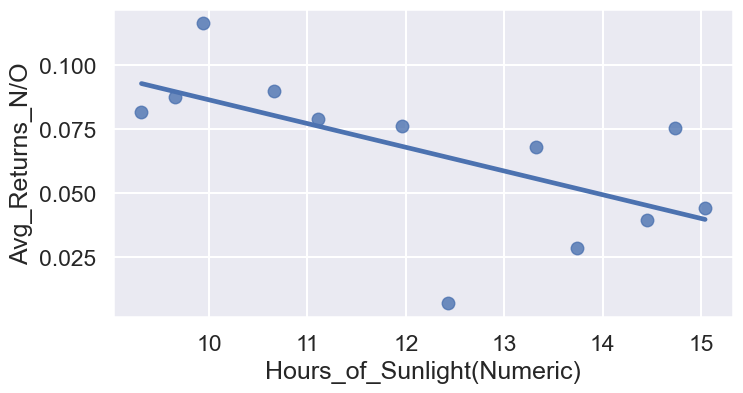

In [47]:
sns.set_theme(style = 'darkgrid', context = 'talk')

plt.figure(figsize=(8,4))
sns.regplot(x=Monthly_NYC['Hours_of_Sunlight(Numeric)'], y = Monthly_NYC['Avg_Returns_N/O'], ci=None)